In [11]:
# 0.0 import packages

import sys
import string

import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plot

In [16]:
# midi mappings from groove dataset
# kick drum
BASS = 36
# snare drum
SNARE_HEAD = 38
SNARE_RIM = 40
SNARE_X_STICK = 37
# toms
TOM_1_HEAD = 48
TOM_1_RIM = 50
TOM_2_HEAD = 45
TOM_2_RIM = 47
TOM_3_HEAD = 43
TOM_3_RIM = 58
# hi-hats
HH_OPEN_BOW = 46
HH_OPEN_EDGE = 26
HH_CLOSED_BOW = 42
HH_CLOSED_EDGE = 22
HH_PEDAL = 44
# crash cymbal
CRASH_1_BOW = 49
CRASH_1_EDGE = 55
CRASH_2_BOW = 57
CRASH_2_EDGE = 52
# ride cymbal
RIDE_BOW = 51
RIDE_EDGE = 59
RIDE_BELL = 53

# mappings for our own training (9)
KICK = 0
SNARE = 1
TOM_1 = 2
TOM_2 = 3
TOM_3 = 4
HH_OPEN = 5
HH_CLOSED = 6
CRASH = 7
RIDE = 8
# groove mappings to our mappings
KICK_LIST = [BASS]
SNARE_LIST = [SNARE_HEAD, SNARE_RIM, SNARE_X_STICK]
TOM_1_LIST = [TOM_1_HEAD, TOM_1_RIM]
TOM_2_LIST = [TOM_2_HEAD, TOM_2_RIM]
TOM_3_LIST = [TOM_3_HEAD, TOM_3_RIM]
HH_OPEN_LIST = [HH_OPEN_BOW, HH_OPEN_EDGE]
HH_CLOSED_LIST = [HH_CLOSED_BOW, HH_CLOSED_EDGE, HH_PEDAL]
CRASH_LIST = [CRASH_1_BOW, CRASH_1_EDGE, CRASH_2_BOW, CRASH_2_EDGE]
RIDE_LIST = [RIDE_BOW, RIDE_EDGE, RIDE_BELL]

In [12]:
# #1.1 GPU stuff

# print ("cuda: ", torch.cuda.is_available())
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# print ("current device: ", device)
# print ("count: ", torch.cuda.device_count())

# if torch.cuda.is_available():
#     print ("device name: ", torch.cuda.get_device_name(0))
#     torch.cuda.set_device(0)

In [13]:
# 1.2 load groove dataset
import math

groove_csv = pd.read_csv('groove/info.csv')
print("groove dataset:", len(groove_csv))

# get train, test, and validation sets
train_csv = []
test_csv = []
validation_csv = []

for index, row in groove_csv.iterrows():
    if str(row.audio_filename).lower() != "nan":
        split = row['split']
        if split == "train":
            train_csv.append(row)
        elif split == "test":
            test_csv.append(row)
        elif split == "validation":
            validation_csv.append(row)
        
print ("train: ", len(train_csv))
print ("test: ", len(test_csv))
print ("validation: ", len(validation_csv))

print (train_csv[0].midi_filename)

groove dataset: 1150
train:  846
test:  124
validation:  120
drummer1/session1/1_funk_80_beat_4-4.mid


In [14]:
import mido

# code to convert midi file to array
# https://medium.com/analytics-vidhya/convert-midi-file-to-numpy-array-in-python-7d00531890c
def msg2dict(msg):
    result = dict()
    if 'note_on' in msg:
        on_ = True
    elif 'note_off' in msg:
        on_ = False
    else:
        on_ = None
    result['time'] = int(msg[msg.rfind('time'):].split(' ')[0].split('=')[1].translate(
        str.maketrans({a: None for a in string.punctuation})))

    if on_ is not None:
        for k in ['note', 'velocity']:
            result[k] = int(msg[msg.rfind(k):].split(' ')[0].split('=')[1].translate(
                str.maketrans({a: None for a in string.punctuation})))
    return [result, on_]

def switch_note(last_state, note, velocity, on_=True):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of this range will be ignored
    result = [0] * 88 if last_state is None else last_state.copy()
    if 21 <= note <= 108:
        value = 1 if velocity > 0 else 0
        result[note-21] = value if on_ else 0
    return result

def get_new_state(new_msg, last_state):
    new_msg, on_ = msg2dict(str(new_msg))
    new_state = switch_note(last_state, note=new_msg['note'], velocity=new_msg['velocity'], on_=on_) if on_ is not None else last_state
    return [new_state, new_msg['time']]

def track2seq(track):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of the id range will be ignored
    result = []
    last_state, last_time = get_new_state(str(track[0]), [0]*88)
    for i in range(1, len(track)):
        new_state, new_time = get_new_state(track[i], last_state)
        if new_time > 0:
            result += [last_state]*new_time
        last_state, last_time = new_state, new_time
    return result

def mid2array(mid, min_msg_pct=0.1):
    tracks_len = [len(tr) for tr in mid.tracks]
    min_n_msg = max(tracks_len) * min_msg_pct
    # convert each track to nested list
    all_arys = []
    for i in range(len(mid.tracks)):
        if len(mid.tracks[i]) > min_n_msg:
            ary_i = track2seq(mid.tracks[i])
            all_arys.append(ary_i)
    # make all nested list the same length
    max_len = max([len(ary) for ary in all_arys])
    for i in range(len(all_arys)):
        if len(all_arys[i]) < max_len:
            all_arys[i] += [[0] * 88] * (max_len - len(all_arys[i]))
    all_arys = np.array(all_arys)
    all_arys = all_arys.max(axis=0)
    # trim: remove consecutive 0s in the beginning and at the end
    sums = all_arys.sum(axis=1)
    ends = np.where(sums > 0)[0]
    return all_arys[min(ends): max(ends)]

drummer1/session1/1_funk_80_beat_4-4.wav


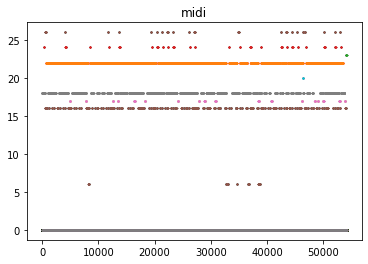

	tensor:  torch.Size([1000, 128])
	tensor:  torch.Size([1000, 128])
	tensor:  torch.Size([1000, 128])
	tensor:  torch.Size([1000, 128])
	tensor:  torch.Size([1000, 128])
	tensor:  torch.Size([1000, 128])
	tensor:  torch.Size([1000, 128])
	tensor:  torch.Size([1000, 128])
	tensor:  torch.Size([1000, 128])


In [15]:
# convert audio files into tensors
import imp
from scipy import signal
import audiosegment
import librosa
import torch
import shutil
import os

# converts an audio file to tensor
def audio_to_melspec_tensor(wav_file_path, sample_rate=44_100): 
    window_size = 0.025
    window_stride = 0.01
    n_dft = int(sample_rate * window_size)
    n_mels = 128
    win_length = 1024
    hop_length = int(sample_rate * window_stride)
    # load in wav file and remove the mean of the signal
    y, sr = librosa.load(wav_file_path, sr=sample_rate)
    y = y - y.mean()
    y = np.append(y[0],y[1:]-.97*y[:-1])
    # compute mel spectrogram
    stft = librosa.stft(y, n_fft=n_dft, hop_length=hop_length, win_length=win_length, window=signal.hamming)
    spec = np.abs(stft)**2
    mel_basis = librosa.filters.mel(sr=sample_rate, n_fft=n_dft, n_mels=n_mels, fmin=20)
    melspec = np.dot(mel_basis, spec)
    logspec = librosa.power_to_db(melspec, ref=np.max)
    logspec = np.transpose(logspec)
    # plot.imshow(logspec.T, origin='lower', aspect='auto')
    # plot.show()
    # turn into tensor
    logspec_tensor = torch.tensor(logspec)
    return logspec_tensor


def get_feats_and_labels_from_csv(csv_index):
    # load in wav file
    audio_file_path = "groove/" + csv_index.audio_filename
    wav_file = audiosegment.from_file(audio_file_path)
    # convert sample width if not set to 2 (16 bits)
    if wav_file.sample_width != 2:
        wav_file = wav_file.set_sample_width(2)
        # print("\tnew sample_width: ", wav_file.sample_width)
        wav_file.export(audio_file_path, format="wav")
    # convert file from stereo to mono if channels > 1
    if wav_file.channels != 1:
        wav_file = wav_file.set_channels(1)
        wav_file.export(audio_file_path, format="wav")
    # cutting and padding
    predefined_length = 9.99
    diced_wav_files = wav_file.dice(predefined_length, zero_pad=True)
    # get feature tensors
    default_sample_rate = 44100
    target_len = predefined_length * default_sample_rate
    feats_tensors_list = []
    i = 0
    for diced_file in diced_wav_files:
        # pad with zeros if not correct length
        diced_file_len = len(diced_file.to_numpy_array())
        if diced_file_len != target_len:
            zeros = int(target_len - diced_file_len)
            diced_array = np.pad(diced_file.to_numpy_array(), (0, zeros))
            diced_file = audiosegment.from_numpy_array(diced_array, framerate=default_sample_rate)
        # export temp wav file and convert to tensor
        diced_file_path = str(csv_index.id) + "-" + str(i) + ".wav"
        diced_file_path = diced_file_path.replace('/', '-')
        diced_file_path = "temp/" + diced_file_path
        diced_file.export(diced_file_path, format="wav")
        feats_tensor = audio_to_melspec_tensor(diced_file_path, wav_file.frame_rate)
        feats_tensors_list.append(feats_tensor)
        i += 1
        
    # load in midi file
    midi_file_path = "groove/" + csv_index.midi_filename
    midi = mido.MidiFile(midi_file_path)
    midi_array = mid2array(midi)
    plot.plot(range(midi_array.shape[0]), np.multiply(np.where(midi_array>0, 1, 0), range(1, 89)), marker='.', markersize=1, linestyle='')
    plot.title("midi")
    plot.show()
    
    # for i in range(len(midi_array)):
    #     print (midi_array[i])
    
    
    
    # return tensors
    return feats_tensors_list #, label_tensor

# reset temp folder
if os.path.isfile('temp/'):
    shutil.rmtree('temp/', ignore_errors=True)
    os.mkdir('temp/')

print (train_csv[0].audio_filename)
feats_tensors = get_feats_and_labels_from_csv(train_csv[0])
for tensor in feats_tensors:
    print ("\ttensor: ", tensor.shape)

# i = 0
# for index in train_csv:
#     feats_tensors = get_feats_and_labels_from_csv(index) # , label_tensor
#     for tensor in feats_tensors:
#         print (i, "\ttensor: ", tensor.shape)

#     i += 1